In [1]:
!git clone https://github.com/moritzwilksch/RossmannSalesPrediction.git
!cd RossmannSalesPrediction

Cloning into 'RossmannSalesPrediction'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 298 (delta 21), reused 32 (delta 11), pack-reused 249
Receiving objects: 100% (298/298), 362.70 MiB | 39.18 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (45/45), done.


In [108]:
import sys
import pathlib

sys.path.append(str(pathlib.Path("..").resolve().parent.parent))
from RossmannSalesPrediction.helpers.dataprep import timeseries_ttsplit, fix_df, prep_for_model
from RossmannSalesPrediction.helpers import feature_engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



root_path = "RossmannSalesPrediction/"

#%%
train = pd.read_csv(root_path + 'data/train.csv')
train = fix_df(train)

# ONLY SUBSAMPLE
# train = train.sample(int(0.5 * len(train)), random_state=42)

# ADD ELAPSED
promo_elapsed = (
    train.groupby('date').mean().reset_index()
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
    [['date', 'elapsed_promo_fwd', 'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd', 'elapsed_schoolholiday_backwd']]
)

train = pd.merge(train, promo_elapsed, on=["date"], how='left')


xtrain_raw, xval_raw, ytrain_raw, yval_raw = timeseries_ttsplit(train, train_pct=0.9)



xtrain, ytrain = (
    xtrain_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .drop(["competitionopensincemonth", "competitionopensinceyear"], axis=1)
    .pipe(prep_for_model, y=ytrain_raw)  # must be last, returns x,y tuple
)

#%%
xval, yval = (
    xval_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .drop(["competitionopensincemonth", "competitionopensinceyear"], axis=1)
    .pipe(prep_for_model, y=yval_raw)  # must be last, returns x,y tuple
)


assert (xtrain.index == ytrain.index).all()



#%%
embedding_fts = "store dayofweek dayofyear stateholiday monthofyear dayofmonth storetype assortment promointerval weekofyear elapsed_promo_fwd elapsed_promo_backwd elapsed_schoolholiday_fwd elapsed_schoolholiday_backwd".split()

to_be_encoded = embedding_fts#"stateholiday storetype assortment promointerval weekofyear".split()
to_be_scaled = "avg_store_customers avg_store_sales competitiondistance competitionopen".split()
leaveasis = "promo schoolholiday promo2".split()
#leaveasis = [x for x in leaveasis if x not in embedding_fts]

#%%
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

oe = OrdinalEncoder()
ss = StandardScaler()

ct = ColumnTransformer([
    ('leavasis', 'passthrough', leaveasis),
    ("ordinalencode", oe, to_be_encoded),
    ("standardscale", ss, to_be_scaled),
])

ct.fit(xtrain)

#%%
xtrain_nn = pd.DataFrame(ct.transform(xtrain), columns=leaveasis + to_be_encoded + to_be_scaled)
xval_nn = pd.DataFrame(ct.transform(xval), columns=leaveasis + to_be_encoded + to_be_scaled)

#%%
# Train numeric/embedding split
xtrain_nn_num = xtrain_nn.loc[:, ~xtrain_nn.columns.isin(embedding_fts)].values
xtrain_nn_emb = xtrain_nn.loc[:, embedding_fts].values

# Validation numeric/embedding split
xval_nn_num = xval_nn.loc[:, ~xval_nn.columns.isin(embedding_fts)].values
xval_nn_emb = xval_nn.loc[:, embedding_fts].values


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [136]:
# Baseline
from RossmannSalesPrediction.helpers.evaluation import rmspcte
baseline = ytrain.to_frame().groupby(xtrain.store)['sales'].mean()
preds = pd.merge(xval, baseline, on='store', how='left')['sales']
print(rmspcte(yval.values, preds.values))

overallmean = ytrain.mean()
preds = np.full(yval.shape, overallmean)
print(rmspcte(yval.values, preds))


0.30716532620407844
0.5358402783337523


In [110]:
from keras import backend as K
def rmspe_loss(y_true, y_pred):
    sum = K.sqrt(K.mean(K.square( (y_true - y_pred) / (K.clip(K.abs(y_true), K.epsilon(), None) + 1e-6) ), axis=-1) )
    return sum*100

rmspe_loss(K.constant(yval.values), K.constant(preds.values.flatten()))

<tf.Tensor: shape=(), dtype=float32, numpy=30.716532>

In [111]:
for x in [train, xtrain, xtrain_nn, xtrain_nn_num, xtrain_nn_emb]:
    print(x.shape)

print(xtrain_raw.date.min())
print(xtrain_raw.date.max())

print(xval_raw.date.min())
print(xval_raw.date.max())

(1017209, 13)
(756504, 21)
(756504, 21)
(756504, 7)
(756504, 14)
2013-01-01 00:00:00
2015-04-27 00:00:00
2015-04-28 00:00:00
2015-07-31 00:00:00


In [126]:

#%%
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

dimtable = {k: v for k, v in zip(embedding_fts, [xtrain_nn[col].nunique() for col in embedding_fts])}
#%%
num_input = keras.Input(shape=(xtrain_nn_num.shape[1], ))
emb_inputs = [keras.Input(shape=(1, )) for _ in embedding_fts]

emb_table = {
    'store': 10,
    'dayofweek': 6,
    'dayofyear': 6,
    'stateholiday': 2,
    'monthofyear': 6,
    'weekofyear': 5,
    'dayofmonth': 10,
    'storetype': 2,
    'assortment': 2,
    'promointerval': 2,
    'elapsed_promo_fwd': 5,
    'elapsed_promo_backwd': 5,
    'elapsed_schoolholiday_fwd': 5,
    'elapsed_schoolholiday_backwd': 5,
}



emb_layers = [keras.layers.Embedding(input_dim=dimtable[col]+1, output_dim=emb_table[col])(emb_inputs[idx]) for idx, col in enumerate(embedding_fts)]


flats = [keras.layers.Flatten()(x) for x in emb_layers + [num_input]]
concat = keras.layers.Concatenate()(flats)
# concat = keras.layers.BatchNormalization()(concat)
#concat = keras.layers.Dropout(0.2)(concat)

hidden_dense = keras.layers.Dense(units=2**9, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(concat)
# hidden_dense = keras.layers.BatchNormalization()(hidden_dense)
hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)
# hidden_dense = keras.layers.Dense(units=64, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(hidden_dense)

hidden_dense = keras.layers.Dense(units=2**13, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(hidden_dense)
# hidden_dense = keras.layers.BatchNormalization()(hidden_dense)
hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)



out = keras.layers.Dense(units=1, activation='linear', )(hidden_dense) # bias_initializer=keras.initializers.Constant(ytrain.mean())

model: keras.Model = keras.Model(inputs=emb_inputs + [num_input], outputs=out)

#%%


train_in = np.split(xtrain_nn_emb, xtrain_nn_emb.shape[-1], axis=1) + [xtrain_nn_num]
val_in = np.split(xval_nn_emb, xval_nn_emb.shape[-1], axis=1) + [xval_nn_num]
print(f"Input shape = (nrows, {sum(x.shape[1] for x in train_in)})")

# -> log -> SS y values
SCALE_TARGET = False
if SCALE_TARGET:
    from sklearn.preprocessing import MinMaxScaler
    print("[CAUTION] Scaling target!")
    y_ss = MinMaxScaler() #StandardScaler()
    y_ss.fit(np.log(ytrain.values.reshape(-1, 1)))
    ytrain_scaled = y_ss.transform(np.log(ytrain.values.reshape(-1, 1)))
    yval_scaled = y_ss.transform(np.log(yval.values.reshape(-1, 1)))

from tensorflow.keras import backend as K
def rmspe_loss(y_true, y_pred):
    sum = K.sqrt(K.mean(K.square( (y_true - y_pred) /
          K.clip(K.abs(y_true), K.epsilon(), None) + 1e-6 ), axis=-1) )
    return sum*100

from RossmannSalesPrediction.helpers import lr_finder
lrf = lr_finder.LRFinder(1e-6, 1e-1)
model.compile(optimizer='adam', loss=rmspe_loss, metrics=[rmspe_loss])
# model.fit(x=train_in, y=ytrain.values.flatten().astype(np.float32), callbacks=[lrf], validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=1, batch_size=512)



Input shape = (nrows, 21)


([<matplotlib.axis.XTick at 0x7fc7000e6250>,
 <a list of 8 Text major ticklabel objects>)

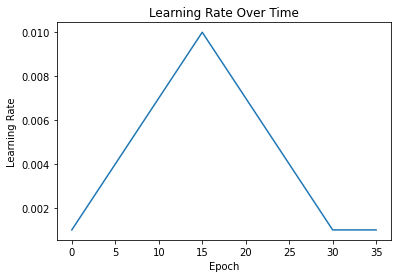

In [127]:
EPOCHS=30
def clr_scheduler(epoch, lr):

    maxlr = 10**-2
    minlr = 1e-3

    if epoch > EPOCHS:
        return minlr

    step_size = (maxlr - minlr)/(EPOCHS/2)
    return maxlr - np.abs(EPOCHS/2 - epoch)*step_size
plt.plot([clr_scheduler(x, 0) for x in range(36)])
plt.title("Learning Rate Over Time")
plt.xlabel("Epoch",)
plt.ylabel("Learning Rate",)
plt.xticks([x for x in range(0, 36, 5)])


In [128]:
mcp = ModelCheckpoint('modelcheckpoint', save_best_only=True, save_weights_only=True)

if SCALE_TARGET:
    model.compile(optimizer=keras.optimizers.Adam(1e-2), loss='mean_absolute_error', metrics=['mean_absolute_error'])
    hist = model.fit(x=train_in, y=ytrain_scaled.astype(np.float32), validation_data=(val_in, yval_scaled.flatten().astype(np.float32)), epochs=10, batch_size=512, callbacks=[mcp])
else:
    model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=rmspe_loss, metrics=[rmspe_loss])
    #hist = model.fit(x=train_in, y=ytrain.values.flatten().astype(np.float32), validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=10, batch_size=256, callbacks=[mcp, keras.callbacks.ReduceLROnPlateau(patience=2)])
    hist = model.fit(x=train_in, y=ytrain.values.flatten().astype(np.float32), validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=35, batch_size=512, callbacks=[mcp, keras.callbacks.LearningRateScheduler(clr_scheduler)])

    # SANITY CHECK: # hist = model.fit(x=[x[:2] for x in train_in], y=ytrain.values.flatten()[:2].astype(np.float32), epochs=100, batch_size=32)



model.load_weights("modelcheckpoint")

Epoch 1/35
1478/1478 [==============================] - 19s 11ms/step - loss: 38.0355 - rmspe_loss: 32.9903 - val_loss: 17.1992 - val_rmspe_loss: 15.2225
Epoch 2/35
1478/1478 [==============================] - 16s 11ms/step - loss: 15.2918 - rmspe_loss: 13.5778 - val_loss: 16.1694 - val_rmspe_loss: 14.9496
Epoch 3/35
1478/1478 [==============================] - 17s 11ms/step - loss: 14.5352 - rmspe_loss: 13.3699 - val_loss: 16.2437 - val_rmspe_loss: 15.2843
Epoch 4/35
1478/1478 [==============================] - 17s 11ms/step - loss: 14.1389 - rmspe_loss: 13.1239 - val_loss: 14.6748 - val_rmspe_loss: 13.1001
Epoch 5/35
1478/1478 [==============================] - 16s 11ms/step - loss: 12.3484 - rmspe_loss: 10.8416 - val_loss: 14.7552 - val_rmspe_loss: 13.3872
Epoch 6/35
1478/1478 [==============================] - 16s 11ms/step - loss: 11.4521 - rmspe_loss: 10.0717 - val_loss: 14.1530 - val_rmspe_loss: 12.9700
Epoch 7/35
1478/1478 [==============================] - 16s 11ms/step - loss

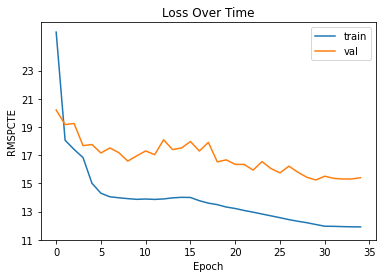

0.15661831095023665
tf.Tensor(15.66184, shape=(), dtype=float32)


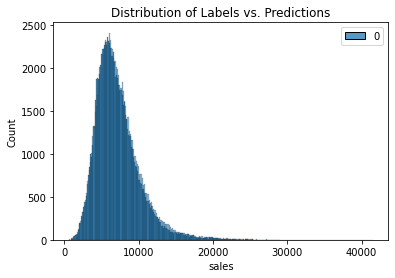

In [131]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title("Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("RMSPCTE")
plt.legend()
plt.show()

preds = model.predict(val_in)

if SCALE_TARGET:
    preds = np.exp(y_ss.inverse_transform(preds))


from RossmannSalesPrediction.helpers.evaluation import rmspcte

print(rmspcte(yval, preds))
print(rmspe_loss(K.constant(yval.values.flatten()), K.constant(preds.flatten())))

import seaborn as sns
sns.histplot(preds, color='orange')
sns.histplot(yval, alpha=0.5)
plt.title("Distribution of Labels vs. Predictions")
plt.show()

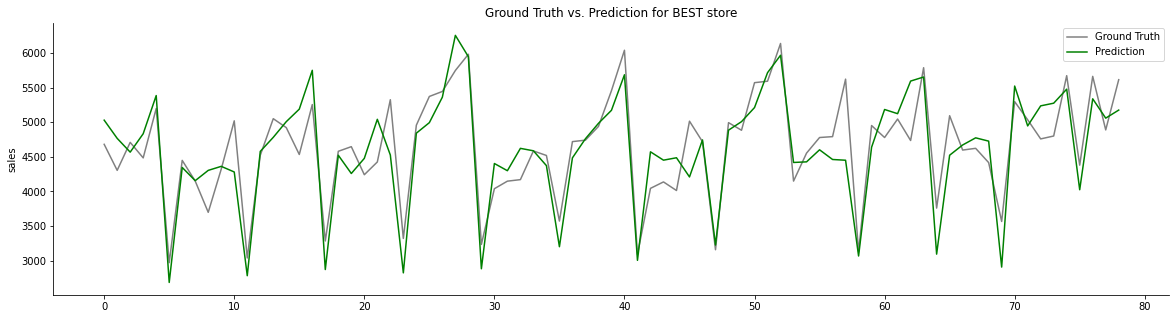

In [117]:
evaldf = pd.DataFrame({
    'real': yval.values.flatten(),
    'pred': preds.flatten(),
    'abs_pcterr': (preds.flatten() - yval.values.flatten())/yval.values.flatten(),
    'sq_pcterr': ((preds.flatten() - yval.values.flatten())/yval.values.flatten())**2,
})

# storeid starts at 1, argmin at 0
#best_store = evaldf.abs_pcterr.abs().groupby(xval.store).mean().argmin() + 1
#worst_store = evaldf.abs_pcterr.abs().groupby(xval.store).mean().argmax() + 1

best_store = (evaldf.sq_pcterr.groupby(xval.store).mean()**0.5).argmin() + 1
worst_store = (evaldf.sq_pcterr.groupby(xval.store).mean()**0.5).argmax() + 1

fig, ax = plt.subplots(figsize=(20, 5))
filtered = pd.concat([xval, yval, pd.Series(preds.flatten())], axis=1).rename({0: 'pred'}, axis=1).query("(store == @best_store) & (sales>0)")
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='sales', color='grey', label='Ground Truth')
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='pred', color='green', label='Prediction')
ax.set(
    title="Ground Truth vs. Prediction for BEST store"
)
sns.despine()

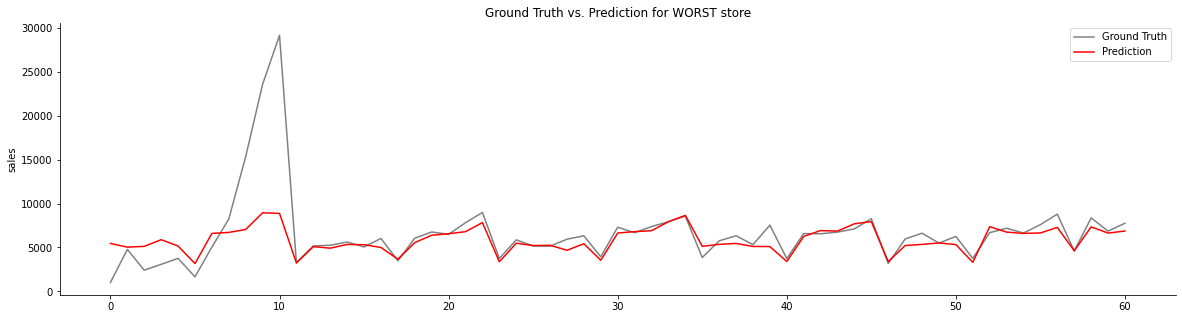

In [118]:
fig, ax = plt.subplots(figsize=(20, 5))
filtered = pd.concat([xval, yval, pd.Series(preds.flatten())], axis=1).rename({0: 'pred'}, axis=1).query("(store == @worst_store) & (sales>0)")
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='sales', color='grey', label='Ground Truth')
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='pred', color='red', label='Prediction')
ax.set(
    title="Ground Truth vs. Prediction for WORST store"
);
sns.despine()

In [ ]:
errors = pd.DataFrame({'real': yval, 'preds': preds.flatten()}).assign(delta=lambda row: row.preds - row.real)
worst_lower_5 = errors.delta < np.quantile(errors.delta, 0.01)
worst_upper_5 = errors.delta > np.quantile(errors.delta, 0.99)
errors = errors.assign(worst=(worst_lower_5 | worst_upper_5))
errors

,real,preds,delta,worst
0,5263,6481.960938,1218.960938,False
1,6064,6480.181152,416.181152,False
2,8314,9805.083008,1491.083008,False
3,13995,12535.518555,-1459.481445,False
4,4822,6693.187012,1871.187012,False
...,...,...,...,...
175076,1773,3101.520020,1328.520020,False
175077,6787,7745.763184,958.763184,False
175078,4382,5113.150879,731.150879,False
175079,18629,18646.308594,17.308594,False


In [97]:
re_train = [np.vstack([train_in[i], val_in[i]]) for i in range(len(train_in))]
re_y = np.vstack([ytrain.values.reshape(-1, 1), yval.values.reshape(-1, 1)])


#model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=rmspe_loss, metrics=[rmspe_loss])
#hist = model.fit(x=re_train, y=re_y.astype(np.float32), validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=10, batch_size=512, callbacks=[mcp])

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=rmspe_loss, metrics=[rmspe_loss])
model.fit(x=re_train, y=re_y.flatten().astype(np.float32), validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=25, batch_size=512, callbacks=[mcp, keras.callbacks.LearningRateScheduler(clr_scheduler)])

model.load_weights("modelcheckpoint")

Epoch 1/25
1650/1650 [==============================] - 20s 11ms/step - loss: 1.0979 - rmspe_loss: 0.6815 - val_loss: 0.4164 - val_rmspe_loss: 0.3888
Epoch 2/25
1650/1650 [==============================] - 18s 11ms/step - loss: 0.4637 - rmspe_loss: 0.2988 - val_loss: 0.2633 - val_rmspe_loss: 0.1979
Epoch 3/25
1650/1650 [==============================] - 18s 11ms/step - loss: 0.3177 - rmspe_loss: 0.2332 - val_loss: 0.2700 - val_rmspe_loss: 0.2352
Epoch 4/25
1650/1650 [==============================] - 18s 11ms/step - loss: 0.3061 - rmspe_loss: 0.2237 - val_loss: 0.3675 - val_rmspe_loss: 0.1946
Epoch 5/25
1650/1650 [==============================] - 17s 11ms/step - loss: 0.3202 - rmspe_loss: 0.2303 - val_loss: 0.2504 - val_rmspe_loss: 0.1938
Epoch 6/25
1650/1650 [==============================] - 18s 11ms/step - loss: 0.4381 - rmspe_loss: 0.2385 - val_loss: 0.2616 - val_rmspe_loss: 0.1973
Epoch 7/25
1650/1650 [==============================] - 17s 11ms/step - loss: 0.5340 - rmspe_loss: 0

In [ ]:
#xval.groupby(errors.worst).mean()
errors.groupby(xval.store).mean().sort_values('delta')

,real,preds,delta,worst
store,,,,
192,13028.352564,7067.925781,-5960.426758,0.775641
262,21119.000000,17406.083984,-3712.915527,0.243386
827,14688.726115,11127.076172,-3561.649658,0.273885
1114,22099.114650,18853.486328,-3245.627930,0.235669
259,13146.735450,9915.023438,-3231.712158,0.211640
...,...,...,...,...
169,6052.320513,7456.936523,1404.615967,0.141026
905,6891.403846,8308.721680,1417.318115,0.128205
113,5946.012821,7637.097656,1691.084839,0.301282


# Hyperparameter Optimization


In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 4.1MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 1.2MB 51.9MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
     |████████████████████████████████| 143kB 55.2MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 481kB 52.1MB/s 
  Created wheel for alembic: filename=alembic-1.5.5-py2.py3-none-any.whl size=156597 sha256=f042e00fa8f3712e7317e0b004cd18457f716f9db4e96112a41fb1cfaa689476
  Stored in directory: /root/.cache/pip/wheels/74/3f/61/7de6e3cef766d2680a5d81b1a388286e640f6a681eb589d643
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=0d60ec0b11eb971a6452d3b177faffd1e1b3f08f810b42764c81e7865cf2f5f4
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256

In [ ]:
import optuna
from RossmannSalesPrediction.helpers.evaluation import rmspcte

def objective(trial):
    dimtable = {k: v for k, v in zip(embedding_fts, [xtrain_nn[col].nunique() for col in embedding_fts])}

    num_input = keras.Input(shape=(xtrain_nn_num.shape[1], ))
    emb_inputs = [keras.Input(shape=(1, )) for _ in embedding_fts]

    emb_table = {
        'store': 10,
        'dayofweek': 6,
        'dayofyear': 6,
        'stateholiday': 2,
        'monthofyear': 6,
        'weekofyear': 5,
        'dayofmonth': 10,
        'storetype': 2,
        'assortment': 2,
        'promointerval': 2,
        'elapsed_promo_fwd': 5,
        'elapsed_promo_backwd': 5,
        'elapsed_schoolholiday_fwd': 5,
        'elapsed_schoolholiday_backwd': 5,
    }


    act = trial.suggest_categorical('act_fn', ['relu', 'sigmoid', 'tanh'])
    emb_layers = [keras.layers.Embedding(input_dim=dimtable[col]+1, output_dim=emb_table[col])(emb_inputs[idx]) for idx, col in enumerate(embedding_fts)]
    # num_dense = keras.layers.Dense(units=2**trial.suggest_int('units_numdense', 4, 10), activation=act, kernel_regularizer=keras.regularizers.l2())(num_input)

    #dense1 = keras.layers.Dense(units=64, activation='relu')(num_input)
    flats = [keras.layers.Flatten()(x) for x in emb_layers + [num_input]]
    concat = keras.layers.Concatenate()(flats)


    
    hidden_dense = keras.layers.Dense(units=2**trial.suggest_int('units_1', 5, 15), activation=act, kernel_regularizer=keras.regularizers.l2())(concat)
    hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)
    hidden_dense = keras.layers.Dense(units=2**trial.suggest_int('units_2', 5, 15), activation=act, kernel_regularizer=keras.regularizers.l2())(hidden_dense)
    hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)


    out = keras.layers.Dense(units=1, activation='linear', )(hidden_dense) # bias_initializer=keras.initializers.Constant(ytrain.mean())

    model: keras.Model = keras.Model(inputs=emb_inputs + [num_input], outputs=out)

    from tensorflow.keras.callbacks import ModelCheckpoint

    mcp = ModelCheckpoint('.modelcheckpoint', save_best_only=True, save_weights_only=True)


    model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=rmspe_loss, metrics=[rmspe_loss])

    train_in = np.split(xtrain_nn_emb, xtrain_nn_emb.shape[-1], axis=1) + [xtrain_nn_num]
    val_in = np.split(xval_nn_emb, xval_nn_emb.shape[-1], axis=1) + [xval_nn_num]

    bs = 512 # 2**trial.suggest_int('bs', 6, 11)
    model.fit(x=train_in, y=ytrain.values.flatten().astype(np.float32), validation_data=(val_in, yval.values.flatten().astype(np.float32)), epochs=8, batch_size=bs, callbacks=[mcp, keras.callbacks.ReduceLROnPlateau(patience=2)])

    model.load_weights(".modelcheckpoint")

    preds = model.predict(val_in)
    return rmspcte(yval, preds)

#study = optuna.create_study(storage="sqlite:///univariate_optuna.db", study_name="univariate_nn", load_if_exists=True, sampler=optuna.samplers.RandomSampler())
#study.optimize(objective, n_trials=20, )


In [ ]:
#!pip install optuna==2.5.0
#!optuna storage upgrade --storage larger_space_univariate_optuna.db
import optuna
study2 = optuna.load_study('univariate_nn', storage="sqlite:///larger_space_univariate_optuna.db")

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study2)

In [149]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_197 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_198 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_199 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_200 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [98]:
# TEST SUBMISSION

test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
test = fix_df(test_raw.copy())


promo_elapsed = (
    test.groupby('date').mean().reset_index()
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
    [['date', 'elapsed_promo_fwd', 'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd', 'elapsed_schoolholiday_backwd']]
)

test = pd.merge(test, promo_elapsed, on=["date"], how='left')


test = (
    test
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .drop(['date', 'open', 'competitionopensincemonth', 'competitionopensinceyear'], axis=1)
    .rename({'customers': 'avg_store_customers'}, axis=1)
)

embedding_fts = "store dayofweek dayofyear stateholiday monthofyear dayofmonth storetype assortment promointerval weekofyear elapsed_promo_fwd elapsed_promo_backwd elapsed_schoolholiday_fwd elapsed_schoolholiday_backwd".split()

to_be_encoded = embedding_fts#"stateholiday storetype assortment promointerval weekofyear".split()
to_be_scaled = "avg_store_customers avg_store_sales competitiondistance competitionopen".split()
leaveasis = "promo schoolholiday promo2".split()


#%%
xtest_nn = pd.DataFrame(ct.transform(test), columns=leaveasis + to_be_encoded + to_be_scaled)


xtest_nn_num = xtest_nn.loc[:, ~xtest_nn.columns.isin(embedding_fts)].values.astype(np.float64)
xtest_nn_emb = xtest_nn.loc[:, embedding_fts].values.astype(np.long)
test_in = np.split(xtest_nn_emb, xtest_nn_emb.shape[-1], axis=1) + [xtest_nn_num]

preds = model.predict(test_in)



In [99]:
output = pd.DataFrame({'Id': list(range(1, 41089)), 'sales': preds.flatten()})
output.to_csv('dropout_cyclicLR_compopen_tf.csv', index=False)

# A little Plotting

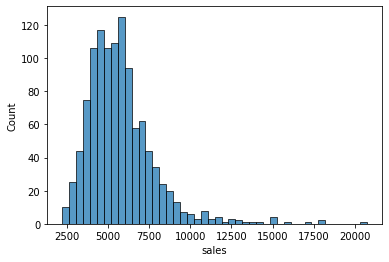

In [ ]:
sns.histplot(train.groupby('store')['sales'].mean())

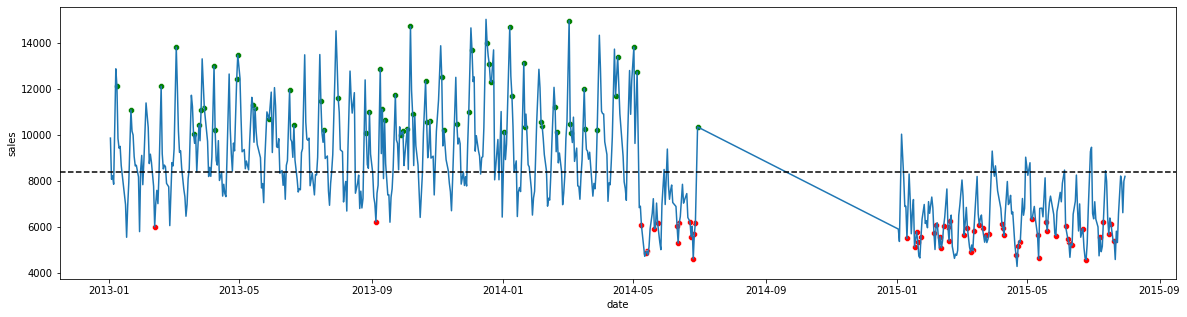

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=train.query("store == 815 & sales > 0"), x='date', y='sales', ci=None, ax=ax)
filtered = train.loc[(train.store == 815) & train.sales > 0]
sns.scatterplot(data=filtered.loc[filtered.sales > np.quantile(filtered.sales, 0.80)], x='date', y='sales', color='green', ax=ax)
sns.scatterplot(data=filtered.loc[filtered.sales < np.quantile(filtered.sales, 0.20)], x='date', y='sales', color='red', ax=ax)


plt.axhline(filtered.sales.mean(), color='k', linestyle='--')



In [ ]:
lower_quantiles = ytrain.groupby(xtrain.store).agg(np.quantile, 0.2)
upper_quantiles = ytrain.groupby(xtrain.store).agg(np.quantile, 0.8)
quantiles = pd.DataFrame({'lowerq': lower_quantiles, 'upperq': upper_quantiles})

_xtrain = pd.merge(xtrain, quantiles, left_on='store', how='left', right_index=True, validate="many_to_many")
_xtrain = _xtrain.assign(lowsales=ytrain < _xtrain.lowerq)
_xtrain = _xtrain.assign(highsales=ytrain > _xtrain.upperq)
_xtrain

NameError: ignored

# TabNet

In [ ]:
!pip install tabnet

In [ ]:
from tabnet import TabNetRegressor
import tensorflow as tf

feature_columns = []
for i, col_name in enumerate(xtrain_nn.columns):
    feature_columns.append(tf.feature_column.numeric_column(col_name) if col_name not in embedding_fts else 
                           tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_identity(col_name, num_buckets=dimtable[col_name]), dimension=emb_table[col_name])
                           )

# num fts AFTER embedding
tbr = TabNetRegressor(feature_columns=feature_columns, num_features=82, num_regressors=1, feature_dim=20, output_dim=10)

[TabNet]: 10 features will be used for decision steps.


In [ ]:
from keras.callbacks import ModelCheckpoint
mcp_tbr = ModelCheckpoint("TabnetChckpt", save_best_only=True, save_weights_only=True)

tbr.compile('adam', rmspe_loss, metrics=[rmspe_loss])

xtrain_nn[embedding_fts] = xtrain_nn[embedding_fts].astype(np.int8)
xval_nn[embedding_fts] = xval_nn[embedding_fts].astype(np.int8)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(xtrain_nn), ytrain.values.astype(np.float32))).batch(1024)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(xval_nn), yval.values.astype(np.float32))).batch(len(yval))

tbr.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[mcp_tbr])

Epoch 1/25
654/654 [==============================] - 51s 63ms/step - loss: 20.6521 - rmspe_loss: 20.6521 - val_loss: 20.8542 - val_rmspe_loss: 20.8542
Epoch 2/25
654/654 [==============================] - 40s 61ms/step - loss: 19.5706 - rmspe_loss: 19.5706 - val_loss: 20.7448 - val_rmspe_loss: 20.7448
Epoch 3/25
654/654 [==============================] - 39s 60ms/step - loss: 18.6254 - rmspe_loss: 18.6254 - val_loss: 20.7622 - val_rmspe_loss: 20.7622
Epoch 4/25
654/654 [==============================] - 39s 60ms/step - loss: 18.1660 - rmspe_loss: 18.1660 - val_loss: 21.2245 - val_rmspe_loss: 21.2245
Epoch 5/25
654/654 [==============================] - 43s 65ms/step - loss: 17.7619 - rmspe_loss: 17.7619 - val_loss: 21.4497 - val_rmspe_loss: 21.4497
Epoch 6/25
654/654 [==============================] - 42s 64ms/step - loss: 17.7924 - rmspe_loss: 17.7924 - val_loss: 19.4711 - val_rmspe_loss: 19.4711
Epoch 7/25
654/654 [==============================] - 43s 65ms/step - loss: 16.9757 - rm

In [ ]:
tbr.load_weights("TabnetChckpt")
preds = tbr.predict(val_dataset)

In [ ]:
from RossmannSalesPrediction.helpers.evaluation import rmspcte
rmspcte(yval.values.flatten(), preds.flatten())

0.2330365127355089

In [ ]:
import seaborn as sns
import sys
import pathlib
from typing import Union

sys.path.append(str(pathlib.Path("..").resolve().parent.parent))
from RossmannSalesPrediction.helpers.dataprep import timeseries_ttsplit, fix_df, prep_for_model
from RossmannSalesPrediction.helpers.evaluation import rmspcte
from tensorflow import keras
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from RossmannSalesPrediction.helpers import feature_engineering



root_path = "RossmannSalesPrediction/"

#%%


dimtable = {k: v for k, v in zip(embedding_fts, [xtrain_nn[col].nunique() for col in embedding_fts])}

emb_table = {
    'dayofweek': 10, #6,
    'monthofyear': 15, #6,
    'dayofmonth': 10,
    'weekofyear': 25
}

embedding_fts = emb_table.keys()

#%%
num_input = keras.Input(shape=(xtrain_nn_num.shape[1], ))
emb_inputs = [keras.Input(shape=(1, )) for _ in embedding_fts]


#%%

emb_layers = [keras.layers.Embedding(input_dim=dimtable[col]+1, output_dim=emb_table[col])(emb_inputs[idx]) for idx, col in enumerate(embedding_fts)]

#dense1 = keras.layers.Dense(units=64, activation='relu')(num_input)
flats = [keras.layers.Flatten()(x) for x in emb_layers + [num_input]]
concat = keras.layers.Concatenate()(flats)
hidden_dense = keras.layers.Dense(units=512, activation='relu',)(concat)
#hidden_dense = keras.layers.Dense(units=4024, activation='relu',)(hidden_dense)
hidden_dense = keras.layers.Dense(units=4664, activation='relu',)(hidden_dense)
out = keras.layers.Dense(units=1115, activation='linear')(hidden_dense)

model: keras.Model = keras.Model(inputs=emb_inputs + [num_input], outputs=out)

#%%
from tensorflow.keras.callbacks import ModelCheckpoint

mcp = ModelCheckpoint('multivar_modelcheckpoint', save_best_only=True, save_weights_only=True)
model.compile(optimizer=keras.optimizers.Adam(3e-4), loss=rmspe_loss, metrics=[rmspe_loss])

train_in = np.split(xtrain_nn_emb, xtrain_nn_emb.shape[-1], axis=1) + [xtrain_nn_num]
val_in = np.split(xval_nn_emb, xval_nn_emb.shape[-1], axis=1) + [xval_nn_num]

#%%
hist = model.fit(x=train_in, y=ytrain.astype(np.float32), validation_data=(val_in, yval.astype(np.float32)), epochs=10, batch_size=32, callbacks=[mcp])

model.load_weights("multivar_modelcheckpoint")

#%%

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

preds = model.predict(val_in)
#preds = y_ss.inverse_transform(preds)


print(rmspcte(yval, preds))

sns.histplot(preds, color='orange')
sns.histplot(yval)
plt.show()


#%%

# TEST SUBMISSION
if False:
    test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
    test = fix_df(test_raw.copy())
    test = test.groupby('date').mean().drop(['store'], axis=1).reset_index()
    test = feature_engineering.split_date(test).drop('date', axis=1)

    xtest_nn = test.copy()
    xtest_nn_num = xtest_nn.loc[:, ~xtest_nn.columns.isin(embedding_fts)].values.astype(np.float64)
    xtest_nn_emb = xtest_nn.loc[:, embedding_fts].values
    test_in = np.split(xtest_nn_emb, xtest_nn_emb.shape[-1], axis=1) + [xtest_nn_num]

    preds = y_ss.inverse_transform(model.predict(test_in))

    preds_df = pd.melt(pd.DataFrame(preds, index=test_raw.Date.unique()), var_name='Store', value_name='Sales', ignore_index=False).reset_index().rename({'index': 'Date'}, axis=1)
    preds_df['Store'] += 1

    output = pd.merge(test_raw, preds_df, on=['Date', 'Store'], how='left')
    output = output.set_index(output.index+1)
    output['Sales'].to_csv(root_path + "data/multivariate_nn_out.csv", index_label='Id')


Epoch 1/10


ValueError: ignored

In [ ]:
pd.read_csv(root_path + 'data/train.csv').Date.apply([np.min, np.max])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


amin    2013-01-01
amax    2015-07-31
Name: Date, dtype: object

In [ ]:
test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
test = fix_df(test_raw.copy())
test

,store,dayofweek,date,open,promo,stateholiday,schoolholiday
0,1,4,2015-09-17,1.0,1,no,0
1,3,4,2015-09-17,1.0,1,no,0
2,7,4,2015-09-17,1.0,1,no,0
3,8,4,2015-09-17,1.0,1,no,0
4,9,4,2015-09-17,1.0,1,no,0
...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,1.0,0,no,0
41084,1112,6,2015-08-01,1.0,0,no,0
41085,1113,6,2015-08-01,1.0,0,no,0
41086,1114,6,2015-08-01,1.0,0,no,0


In [ ]:
test.date.apply([np.min, np.max])

amin   2015-08-01
amax   2015-09-17
Name: date, dtype: datetime64[ns]

In [ ]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669257 entries, 0 to 669256
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   store                         669257 non-null  int64   
 1   dayofweek                     669257 non-null  int64   
 2   promo                         669257 non-null  int64   
 3   stateholiday                  669257 non-null  category
 4   schoolholiday                 669257 non-null  int64   
 5   elapsed_promo_fwd             669257 non-null  int64   
 6   elapsed_promo_backwd          669257 non-null  int64   
 7   elapsed_schoolholiday_fwd     669257 non-null  int64   
 8   elapsed_schoolholiday_backwd  669257 non-null  int64   
 9   monthofyear                   669257 non-null  int64   
 10  dayofmonth                    669257 non-null  int64   
 11  dayofyear                     669257 non-null  int64   
 12  weekofyear                    

# Random Forest

In [62]:
import sys
import pathlib

sys.path.append(str(pathlib.Path("..").resolve().parent.parent))
from sklearn.linear_model import LinearRegression
import seaborn as sns
from RossmannSalesPrediction.helpers.evaluation import rmspcte
from RossmannSalesPrediction.helpers import lr_finder
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from RossmannSalesPrediction.helpers.dataprep import timeseries_ttsplit, fix_df, prep_for_model
from RossmannSalesPrediction.helpers import feature_engineering
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


#%%
train = pd.read_csv(root_path + 'data/train.csv')
train = fix_df(train)

# ADD ELAPSED
promo_elapsed = (
    train.groupby('date').mean().reset_index()
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
    [['date', 'elapsed_promo_fwd', 'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd', 'elapsed_schoolholiday_backwd']]
)

train = pd.merge(train, promo_elapsed, on=["date"], how='left')


xtrain_raw, xval_raw, ytrain_raw, yval_raw = timeseries_ttsplit(train, train_pct=0.9)


xtrain, ytrain = (
    xtrain_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .drop(["competitionopensincemonth", "competitionopensinceyear"], axis=1)
    .pipe(prep_for_model, y=ytrain_raw)  # must be last, returns x,y tuple
)

#%%
xval, yval = (
    xval_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .drop(["competitionopensincemonth", "competitionopensinceyear"], axis=1)
    .pipe(prep_for_model, y=yval_raw)  # must be last, returns x,y tuple
)


assert (xtrain.index == ytrain.index).all()


#%%

#%%
embedding_fts = "store dayofweek dayofyear stateholiday monthofyear dayofmonth storetype assortment promointerval weekofyear elapsed_promo_fwd elapsed_promo_backwd elapsed_schoolholiday_fwd elapsed_schoolholiday_backwd".split()

xtrain[embedding_fts] = xtrain[embedding_fts].astype('category')
xval[embedding_fts] = xval[embedding_fts].astype('category')

for col in embedding_fts:
    xtrain[col] = xtrain[col].cat.codes
    xval[col] = xval[col].cat.codes
#%%
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

rfr = RandomForestRegressor(n_jobs=-1)
#rfr = LinearRegression(n_jobs=-1)
rfr.fit(xtrain, ytrain)

#%%
preds = rfr.predict(xval)

#%%
rmspcte(yval, preds)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0.31722953409460486

In [ ]:
xall = pd.concat((xtrain, xval), axis=0)
yall = pd.concat((ytrain, yval), axis=0)

rfr.fit(xall, yall)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Prepping Test Submission

In [147]:
# TEST SUBMISSION RANDOM FOREST
if True:
    test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
    test = fix_df(test_raw.copy())
    
    promo_elapsed = (
    test.groupby('date').mean().reset_index()
        .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
        .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
        .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
        .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
        [['date', 'elapsed_promo_fwd', 'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd', 'elapsed_schoolholiday_backwd']]
    )

    test = pd.merge(test, promo_elapsed, on=["date"], how='left')


    xall_raw = pd.concat((xtrain_raw, xval_raw), axis=0)
    yall_raw = pd.concat((ytrain_raw, yval_raw), axis=0)

    xtest = (
        test
        .pipe(feature_engineering.split_date)
        .pipe(feature_engineering.add_avg_customers_per_store, train_data=xall_raw)
        .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xall_raw, ytrain=yall_raw)
        .pipe(feature_engineering.join_store_details)
        .drop(['date', 'open'], axis=1)
        .rename({'customers': 'avg_store_customers'}, axis=1)
        [xval.columns]
    )

    for col in embedding_fts:
        xtest[col] = xtest[col].astype('category')
        xtest[col] = xtest[col].cat.codes

    print(xtest.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   store                         41088 non-null  int16  
 1   dayofweek                     41088 non-null  int8   
 2   promo                         41088 non-null  int64  
 3   stateholiday                  41088 non-null  int8   
 4   schoolholiday                 41088 non-null  int64  
 5   elapsed_promo_fwd             41088 non-null  int8   
 6   elapsed_promo_backwd          41088 non-null  int8   
 7   elapsed_schoolholiday_fwd     41088 non-null  int8   
 8   elapsed_schoolholiday_backwd  41088 non-null  int8   
 9   monthofyear                   41088 non-null  int8   
 10  dayofmonth                    41088 non-null  int8   
 11  dayofyear                     41088 non-null  int8   
 12  weekofyear                    41088 non-null  int8   
 13  a

In [148]:
preds = rfr.predict(xtest)

#train_mean = np.hstack([ytrain.values, yval.values]).mean()
#preds = np.full(len(xtest), train_mean)

submission = pd.DataFrame({'Id': range(1, len(preds)+1), 'sales': preds.flatten()}).set_index('Id')
submission
submission.to_csv("random_forest_submission.csv")

6955.959133664481

In [ ]:
# TEST SUBMISSION NEURAL NET TIMESERIES 
if False:
    test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
    test = fix_df(test_raw.copy())
    test = test.groupby('date').mean().drop(['store'], axis=1).reset_index()
    test = feature_engineering.split_date(test).drop('date', axis=1)

    xtest_nn = test.copy()
    xtest_nn_num = xtest_nn.loc[:, ~xtest_nn.columns.isin(embedding_fts)].values.astype(np.float64)
    xtest_nn_emb = xtest_nn.loc[:, embedding_fts].values
    test_in = np.split(xtest_nn_emb, xtest_nn_emb.shape[-1], axis=1) + [xtest_nn_num]

    preds = y_ss.inverse_transform(model.predict(test_in))

    preds_df = pd.melt(pd.DataFrame(preds, index=test_raw.Date.unique()), var_name='Store', value_name='Sales', ignore_index=False).reset_index().rename({'index': 'Date'}, axis=1)
    preds_df['Store'] += 1

    output = pd.merge(test_raw, preds_df, on=['Date', 'Store'], how='left')
    output = output.set_index(output.index+1)
    output['Sales'].to_csv(root_path + "data/multivariate_nn_out.csv", index_label='Id')


# Per-Day multivariate output

In [ ]:
import seaborn as sns
import sys
import pathlib
from typing import Union

sys.path.append(str(pathlib.Path("..").resolve().parent.parent))
from RossmannSalesPrediction.helpers.dataprep import timeseries_ttsplit, fix_df, prep_for_model
from RossmannSalesPrediction.helpers.evaluation import rmspcte
from tensorflow import keras
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from RossmannSalesPrediction.helpers import feature_engineering
from RossmannSalesPrediction.helpers.evaluation import rmspe_loss


root_path = "RossmannSalesPrediction/"

#%%
train = pd.read_csv(root_path + 'data/train.csv')
train = fix_df(train)
X = train.groupby('date').mean().drop(['store', 'sales', 'customers'], axis=1).reset_index()
y = pd.pivot_table(train, index='date', columns='store', values='sales').fillna(0).values

cutoff = int(len(y) * 0.8)

xtrain_raw = X.iloc[:cutoff]
ytrain = y[:cutoff]

xval_raw = X.iloc[cutoff:]
yval = y[cutoff:]

#%%
xtrain_raw = (
    xtrain_raw
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
)

xval_raw = (
    xval_raw
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
)

#%%
xtrain = feature_engineering.split_date(xtrain_raw).drop('date', axis=1)
xval = feature_engineering.split_date(xval_raw).drop('date', axis=1)


#%%
embedding_fts = "dayofweek monthofyear dayofmonth weekofyear dayofyear promo".split()
to_scale = ['elapsed_promo_fwd',
            'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd',
            'elapsed_schoolholiday_backwd']
#%%
ss = StandardScaler()
ss.fit(xtrain[to_scale])
xtrain[to_scale] = ss.transform(xtrain[to_scale])
xval[to_scale] = ss.transform(xval[to_scale])



#%%
xtrain_nn = xtrain.copy()
xval_nn = xval.copy()

xtrain[embedding_fts] = xtrain[embedding_fts].astype('int64')
xval[embedding_fts] = xval[embedding_fts].astype('int64')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train_wasopen = (xtrain.open > 0.05)
val_wasopen = (xval.open > 0.05)

xtrain = xtrain[train_wasopen]
xval = xval[val_wasopen]

ytrain = ytrain[train_wasopen, :]
yval = yval[val_wasopen, :]


In [ ]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627 entries, 1 to 752
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   dayofweek                     627 non-null    int64  
 1   open                          627 non-null    float64
 2   promo                         627 non-null    int64  
 3   schoolholiday                 627 non-null    float64
 4   elapsed_promo_fwd             627 non-null    float64
 5   elapsed_promo_backwd          627 non-null    float64
 6   elapsed_schoolholiday_fwd     627 non-null    float64
 7   elapsed_schoolholiday_backwd  627 non-null    float64
 8   monthofyear                   627 non-null    int64  
 9   dayofmonth                    627 non-null    int64  
 10  dayofyear                     627 non-null    int64  
 11  weekofyear                    627 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 63.7 KB


In [ ]:
trainset = tf.data.Dataset.from_tensor_slices((dict(xtrain), ytrain.astype(np.float32))).batch(128)
valset = tf.data.Dataset.from_tensor_slices((dict(xval), yval.astype(np.float32))).batch(len(yval))

In [ ]:
for x in trainset.take(1):
    print(x)

({'dayofweek': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6,
       1, 2, 3, 4, 5, 6, 1, 2, 3, 4])>, 'open': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.99641256, 0.99461883, 0.99372197, 0.99282511, 0.99192825,
       0.99103139, 0.99103139, 0.99103139, 0.99103139, 0.99103139,
       0.99103139, 0.99103139, 0.99103139, 0.99282511, 0.99192825,
       0.99282511, 0.99282511, 0.99282511, 0.99282511, 0.99372197,
       0.99372197, 0.99372197, 0.99282511, 0.99282511, 0.99372197,
       0.99372197, 0.99461883, 0.99461883, 0.99461883, 0.99461883,
       0.99461883, 0.99372197])>, 'promo': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1])>, 'schoolholiday': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([1.        , 0.93273543, 0.93273543, 0.10044843, 0.10044843,
       0.10044843, 0.10044843, 0.10044

In [ ]:
feature_cols = []
ftl_inputs = {}

emb_table = {
    'dayofweek': 10, #6,
    'monthofyear': 15, #6,
    'dayofmonth': 10,
    'weekofyear': 25,
    'dayofyear': 5,
    'promo': 2
}


for col in xtrain.columns:
    if col in embedding_fts:
        cat = tf.feature_column.categorical_column_with_vocabulary_list(col, vocabulary_list=xtrain[col].unique())
        emb = tf.feature_column.embedding_column(cat, dimension=emb_table[col])
        feature_cols.append(emb)
        ftl_inputs[col] = tf.keras.Input(shape=(1,), dtype=tf.int8, name=col)

    else:
        num = tf.feature_column.numeric_column(col)
        feature_cols.append(num)
        ftl_inputs[col] = tf.keras.Input(shape=(1,), dtype=tf.float32, name=col)

In [ ]:
ftcols_in = tf.keras.layers.DenseFeatures(feature_cols)(ftl_inputs)




#flats = [keras.layers.Flatten()(x) for x in emb_layers + [num_input]]
# concat = keras.layers.Concatenate()(flats)
# hidden_dense = keras.layers.Dense(units=512, activation='relu',)(concat)

hidden_dense = keras.layers.Dense(units=512, activation='relu',)(ftcols_in)
hidden_dense = keras.layers.Dense(units=512, activation='relu',)(hidden_dense)
out = keras.layers.Dense(units=1115, activation='linear')(hidden_dense)

#model: keras.Model = keras.Model(inputs=emb_inputs + [num_input], outputs=out)
model: keras.Model = keras.Model(inputs=[v for v in ftl_inputs.values()], outputs=out)

#%%
from tensorflow.keras.callbacks import ModelCheckpoint

# mcp = ModelCheckpoint('.modelcheckpoint', save_best_only=True, save_weights_only=True)
model.compile(optimizer=keras.optimizers.Adam(3e-4), loss=rmspe_loss, metrics=[rmspe_loss])


#%%
hist = model.fit(trainset, validation_data=valset, epochs=100)#callbacks=[mcp])

#model.load_weights(".modelcheckpoint")

Epoch 1/100
20/20 [==============================] - 6s 59ms/step - loss: 4484374.8929 - rmspe_loss: 4484374.8929 - val_loss: 1078680.0000 - val_rmspe_loss: 1078680.0000
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 3887129.3214 - rmspe_loss: 3887129.3214 - val_loss: 796469.8125 - val_rmspe_loss: 796469.8125
Epoch 3/100
20/20 [==============================] - 0s 19ms/step - loss: 1862967.2530 - rmspe_loss: 1862967.2530 - val_loss: 565512.1250 - val_rmspe_loss: 565512.1250
Epoch 4/100
20/20 [==============================] - 0s 19ms/step - loss: 1443284.1280 - rmspe_loss: 1443284.1280 - val_loss: 415273.4062 - val_rmspe_loss: 415273.4062
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 817764.4583 - rmspe_loss: 817764.4583 - val_loss: 297734.3750 - val_rmspe_loss: 297734.3750
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 426105.3118 - rmspe_loss: 426105.3118 - val_loss: 229500.1250 - val_rmspe_loss: 229500

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dayofmonth (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dayofweek (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dayofyear (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
elapsed_promo_backwd (InputLaye [(None, 1)]          0                                            
____________________________________________________________________________________________

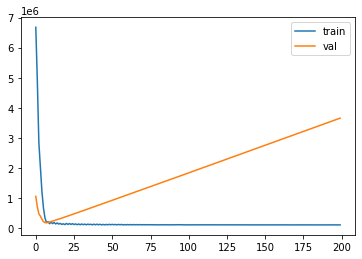

0.9999791242257773


In [ ]:

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

preds = model.predict(valset)
#preds = y_ss.inverse_transform(preds)


print(rmspcte(yval, preds))

sns.histplot(preds, color='orange')
sns.histplot(yval)
plt.show()

In [ ]:
# TEST SUBMISSION MULTI-DIM

test_raw = pd.read_csv(root_path + "data/test.csv").drop('Id', axis=1).reset_index(drop=True)
test = fix_df(test_raw.copy())
test = test.groupby('date').mean().drop(['store'], axis=1).reset_index()
test = feature_engineering.split_date(test).drop('date', axis=1)

xtest_nn = test.copy()
xtest_nn_num = xtest_nn.loc[:, ~xtest_nn.columns.isin(embedding_fts)].values.astype(np.float64)
xtest_nn_emb = xtest_nn.loc[:, embedding_fts].values
test_in = np.split(xtest_nn_emb, xtest_nn_emb.shape[-1], axis=1) + [xtest_nn_num]

preds = y_ss.inverse_transform(model.predict(test_in))

preds_df = pd.melt(pd.DataFrame(preds, index=test_raw.Date.unique()), var_name='Store', value_name='Sales', ignore_index=False).reset_index().rename({'index': 'Date'}, axis=1)
preds_df['Store'] += 1

output = pd.merge(test_raw, preds_df, on=['Date', 'Store'], how='left')
output = output.set_index(output.index+1)
output['Sales'].to_csv(root_path + "data/multivariate_nn_out.csv", index_label='Id')


NameError: ignored

# Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 44kB/s 


In [ ]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(iterations=250, verbose=5, loss_function='MAPE', task_type='CPU', one_hot_max_size=3, leaf_estimation_method="Exact")
cbr.fit(xtrain, ytrain.values, eval_set=(xval, yval.values), cat_features="store dayofweek dayofyear stateholiday monthofyear dayofmonth storetype assortment promointerval weekofyear".split())



0:	learn: 0.3286581	test: 0.3196203	best: 0.3196203 (0)	total: 1.52s	remaining: 6m 18s
5:	learn: 0.3181133	test: 0.3099170	best: 0.3099170 (5)	total: 7.98s	remaining: 5m 24s
10:	learn: 0.3107282	test: 0.3029499	best: 0.3029499 (10)	total: 14.2s	remaining: 5m 9s
15:	learn: 0.3059223	test: 0.2984309	best: 0.2984309 (15)	total: 20.3s	remaining: 4m 57s
20:	learn: 0.3018761	test: 0.2946084	best: 0.2946084 (20)	total: 26.9s	remaining: 4m 52s
25:	learn: 0.2988300	test: 0.2918884	best: 0.2918884 (25)	total: 33s	remaining: 4m 44s
30:	learn: 0.2968526	test: 0.2900956	best: 0.2900956 (30)	total: 39.4s	remaining: 4m 37s
35:	learn: 0.2949254	test: 0.2883299	best: 0.2883299 (35)	total: 45.5s	remaining: 4m 30s
40:	learn: 0.2933070	test: 0.2868211	best: 0.2868211 (40)	total: 51.3s	remaining: 4m 21s
45:	learn: 0.2921607	test: 0.2857181	best: 0.2857181 (45)	total: 57.2s	remaining: 4m 13s
50:	learn: 0.2914429	test: 0.2850235	best: 0.2850235 (50)	total: 1m 3s	remaining: 4m 6s
55:	learn: 0.2906696	test: 0.

0.37516593770019857


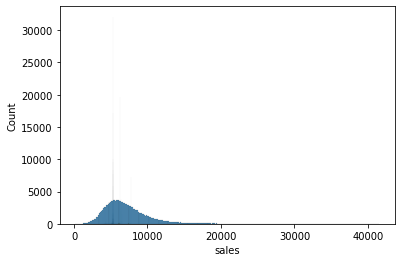

In [ ]:
from RossmannSalesPrediction.helpers.evaluation import rmspcte
import seaborn as sns
preds = cbr.predict(xval)
print(rmspcte(yval, preds))

sns.histplot(preds, color='orange')
sns.histplot(yval)
plt.show()


In [ ]:
xtrain

,store,dayofweek,promo,stateholiday,schoolholiday,elapsed_promo_fwd,elapsed_promo_backwd,elapsed_schoolholiday_fwd,elapsed_schoolholiday_backwd,monthofyear,dayofmonth,dayofyear,weekofyear,avg_store_customers,avg_store_sales,storetype,assortment,competitiondistance,promo2,promointerval,competitionopen
0,1,5,0,no,0,-3,7,-10,14,1,23,23,4,475.488712,3996.416999,c,a,1270.0,0,NotRegular,76.0
1,2,5,0,no,0,-3,7,-10,14,1,23,23,4,486.707835,4114.922975,a,a,570.0,1,"Jan,Apr,Jul,Oct",86.0
2,3,5,0,no,0,-3,7,-10,14,1,23,23,4,625.559097,5741.764940,a,a,14130.0,1,"Jan,Apr,Jul,Oct",97.0
3,4,5,0,no,0,-3,7,-10,14,1,23,23,4,1101.130146,7967.375830,c,c,620.0,0,NotRegular,64.0
4,5,5,0,no,0,-3,7,-10,14,1,23,23,4,445.816733,3869.839309,a,a,29910.0,0,NotRegular,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669252,682,2,0,public,1,-6,16,0,0,1,1,1,1,1749.750332,11106.135458,b,a,150.0,0,NotRegular,76.0
669253,733,2,0,public,1,-6,16,0,0,1,1,1,1,3402.875166,14814.803453,b,b,860.0,0,NotRegular,159.0
669254,769,2,0,public,1,-6,16,0,0,1,1,1,1,2996.671979,10452.855246,b,b,840.0,1,"Jan,Apr,Jul,Oct",0.0
669255,948,2,0,public,1,-6,16,0,0,1,1,1,1,1625.132802,6509.219124,b,b,1430.0,0,NotRegular,0.0


In [ ]:
ytrain

0          3586
1          3206
2          5701
3          7638
4          3962
          ...  
669252     3375
669253    10765
669254     5035
669255     4491
669256     5961
Name: sales, Length: 669257, dtype: int64